# Pytorch learning notebook

This notebook contains content explainedd in pytorch tutorial available at [pytorch.org](pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) and my personal remarks.

Install pytorch using:

```bash
conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
conda install matplotlib
```

# QUICKSTART
## Working with data

Pytorch has two primitives to work with data `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset` stores the samples and their corresponding labels and `DataLoader` wraps and iterable around `Dataset`.

In [1]:
# importing torch

import torch # importing main torch library
from torch import nn # importing torch neural network related submodule
from torch.utils.data import DataLoader # importing DataLoader class
from torchvision import datasets # importing datasets class from vision-specific library torchvision
# other domain specific libraries are torchtext and torchaudio
from torchvision.transforms import ToTensor, Lambda, Compose 

import matplotlib.pyplot as plt # I imported this because I want to visualize data

`torchvision.datasets` contains `Dataset` object for manx real-world vision data like CIFAR, COCO... ([full list](https://pytorch.org/vision/stable/datasets.html))

In [2]:
# Downloading MNIST datasets
training_data = datasets.FashionMNIST(
    root =  "data",
    train = True,
    download = True,
    transform = ToTensor(),
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)

Now loaded and downloaded dataset can be passed to `DataLoader`.

In [3]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


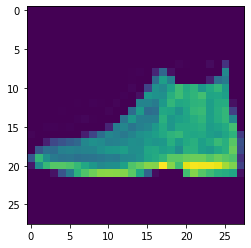

In [4]:

for i, (X, y) in enumerate(test_dataloader):
    print("Shape of X [N, C, H, W]:", X.shape)
    print("Shape of y:", y.shape, y.dtype)
    plt.imshow(X[0,0])
    break # Printing only one pair of data

## Creating models

To define neural net in PyTorch class `nn.Module` is used. Layers are defined in its `__init__` function and in `forward` function we define how the data is passed.

In [5]:
# lets check for GPU availabitlity using
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), 
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
model = NeuralNetwork().to(device)

print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Optimizing the Model Parameters

For training we need an loss function and an optimizer:

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

In one training loop, model makes prediction on the training dataset (fed in batches) and back propagates the predicition error to adjust the model parameters. 

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # compute prediction error
        pred  = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also need to check model performance with test dataset to ensure it is learning.

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Training process is conculded over several epochs. Every epoch trains the model to make better predictions.

In [11]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.322787  [    0/60000]
loss: 2.304651  [ 6400/60000]
loss: 2.288011  [12800/60000]
loss: 2.273408  [19200/60000]
loss: 2.255534  [25600/60000]
loss: 2.237506  [32000/60000]
loss: 2.239688  [38400/60000]
loss: 2.202252  [44800/60000]
loss: 2.207740  [51200/60000]
loss: 2.161169  [57600/60000]
Test Error: 
 Accuracy: 40.8%, Avg loss: 2.166470 

Epoch 2
-------------------------------
loss: 2.188526  [    0/60000]
loss: 2.167712  [ 6400/60000]
loss: 2.113417  [12800/60000]
loss: 2.121492  [19200/60000]
loss: 2.072056  [25600/60000]
loss: 2.029202  [32000/60000]
loss: 2.051613  [38400/60000]
loss: 1.971922  [44800/60000]
loss: 1.986172  [51200/60000]
loss: 1.895779  [57600/60000]
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.905694 

Epoch 3
-------------------------------
loss: 1.952207  [    0/60000]
loss: 1.908237  [ 6400/60000]
loss: 1.797280  [12800/60000]
loss: 1.829275  [19200/60000]
loss: 1.719603  [25600/60000]
loss: 1.690255  [32000/600

Saving the model:

In [12]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading models

In [13]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

to make predictions using trained model:

In [14]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[1][0], test_data[1][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Pullover", Actual: "Pullover"
